In [23]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine
import pandas as pd
import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, normalize, unnormalize
from mpl_toolkits import mplot3d
# from matplotlib import cm
# from alse.utils import read_excel
from alse.alse import alse
import copy

In [24]:
def get_energy_density(v, p, area):
    return p/(v*area)


In [25]:
# Velocity (200-3000), Power (300-2700), Spot Size (1-4)
bounds = torch.tensor([[200, 300, 1], [3000, 2700, 4]])
# initial_training_points = unnormalize(torch.rand(10, 3), bounds)

# v = initial_training_points[:, 0]/60
# p = initial_training_points[:, 1]
# area = (initial_training_points[:, 2]/2)**2 * np.pi

# df = pd.DataFrame(initial_training_points.numpy())
# energy_density = get_energy_density(v, p, area)
# df["energy_density"] = energy_density.numpy()
# df = df[~(df['energy_density'] <5)]
# df = df[~(df['energy_density'] >100)]  
# df.columns = ['V', 'P', 'spot size', 'energy density']
# df = df.round({'V': 0, 'P': 0, 'spot size': 1})
# df

In [26]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}
def read_excel(file_path, x_names, y_names):
                                                        # NaN to 0
    consolidated_data = pd.read_excel(f"{file_path}").fillna(0).loc
    print(consolidated_data[0][0])
    # Input parameters
    input_param = []
    for xname in x_names:
        input_param.append(torch.tensor(consolidated_data[:, f"{xname}"]))

    # Output parameters
    output_param = []
    for yname in y_names:
        output_param.append((torch.tensor((consolidated_data[:, f"{yname}"]))).unsqueeze(-1))

    X = torch.stack(tuple(input_param), -1)
    return X, *output_param

In [27]:
file_path = "/home/jovyan/alse/test_data/8_12_data.xlsx"
df = pd.read_excel(file_path).fillna(0)
x_names = ["V (mm/min)", "P (W)", "spot size (mm)"]
y_names = ["width (mm)", "powder_cap", "wth"]

input_param = []
for xname in x_names:
    input_param.append(torch.tensor(df[xname]))

output_param = []
for yname in y_names:
    output_param.append(torch.tensor(df[yname]).unsqueeze(-1))
X = torch.stack(tuple(input_param), -1)

In [37]:
print(X.shape[1])

torch.Size([20, 3])


In [28]:
    
X, width, pow_cap, wth = read_excel("/home/jovyan/alse/test_data/8_12_data.xlsx",["V (mm/min)", "P (W)", "spot size (mm)"], ["width (mm)", "powder_cap", "wth"])

# X, Y = read_excel("/home/jovyan/alse/test_data/8_4_data.xlsx",["V (mm/min)", "P (W)"], ["width (mm)", "powder_cap", "wth"])

bounds = torch.tensor([[200, 300, 1], [3000, 2700, 4]])
constraints = [("gt", 2.5), ("gt", 0.5), ("gt", 6)]

# algo = alse(X, bounds, [width, pow_cap, wth], constraints)
algo = alse(X, bounds, output_param, constraints)

algo.initialize_model(["reg", "reg", "reg"])

v1


In [22]:
new_pts = algo.next_test_points(5)
print(new_pts)

tensor([[2937.2357, 2550.8720,    4.0000],
        [1345.7047, 1047.9956,    3.9723],
        [1900.9021,  947.4072,    4.0000],
        [1022.2808,  832.1724,    3.5431],
        [1598.7786,  824.2683,    3.5069]], dtype=torch.float64)


In [33]:
df = pd.DataFrame(new_pts.numpy())
df

,0,1,2
0,2937.235713,2550.872040,4.000000
1,1345.704710,1047.995567,3.972339
2,1900.902081,947.407150,4.000000
3,1022.280753,832.172370,3.543101
4,1598.778594,824.268329,3.506893


In [45]:
%matplotlib notebook

N=20
x=np.linspace(bounds[0][0], bounds[1][0], N)
y=np.linspace(bounds[0][1], bounds[1][1], N)
z=np.linspace(bounds[0][2], bounds[1][2], N)

Xplt, Yplt, Zplt = np.meshgrid(x,y,z)
Xplt = torch.from_numpy(Xplt)
Yplt = torch.from_numpy(Yplt)
Zplt = torch.from_numpy(Zplt)

xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1]* Xplt.shape[2],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1]* Yplt.shape[2],)),
        torch.reshape(Zplt, (Zplt.shape[0] * Zplt.shape[1]* Zplt.shape[2],)),
    ),
    dim=1,
)
for model in algo.list_of_models:
    model.eval()
    

# Your 4dimension, only for example (use yours)
predicted_width = algo.list_of_models[0](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
predicted_pow_cap = algo.list_of_models[1](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
predicted_wth = algo.list_of_models[2](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_wth = predicted_wth > 6
printable = (est_width & est_pow_cap & est_wth)

act_width = width > 2.5
act_pow_cap = pow_cap > 0.5
act_wth = wth > 6
act_printable = (act_width & act_pow_cap & act_wth)

In [51]:
X[:,0][act_printable.squeeze()]

tensor([1570., 1270., 1820., 2110., 1030., 2370., 1240., 1040., 1840., 1420.,
        1620., 1050.,  870.,  750.,  650.,  790.], dtype=torch.float64)

<IPython.core.display.Javascript object>


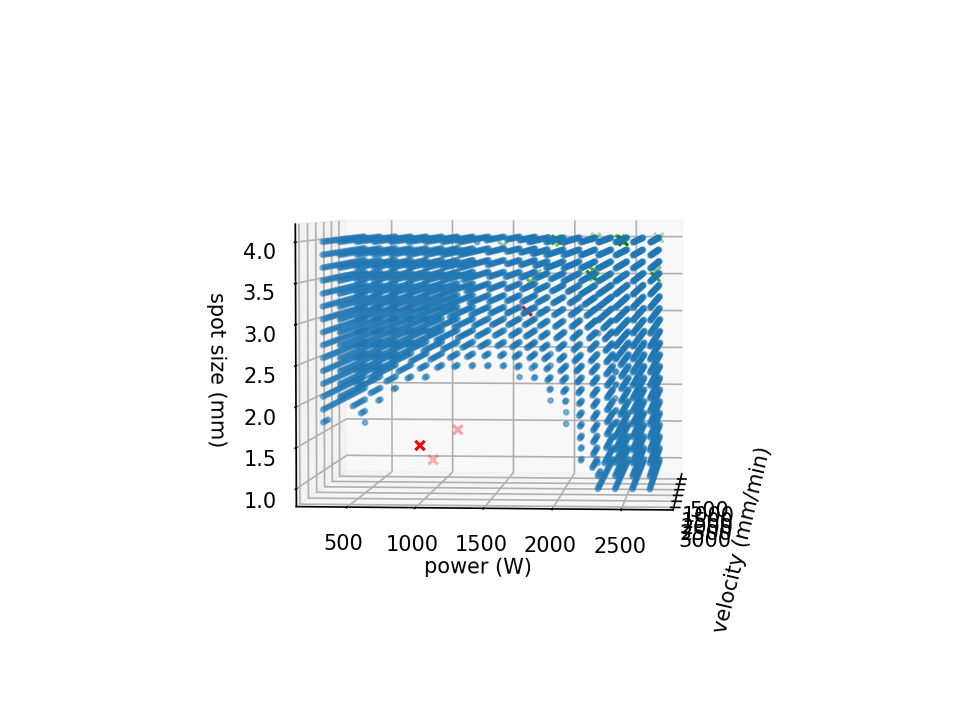

In [53]:
%matplotlib notebook

N=20
x=np.linspace(bounds[0][0], bounds[1][0], N)
y=np.linspace(bounds[0][1], bounds[1][1], N)
z=np.linspace(bounds[0][2], bounds[1][2], N)

Xplt, Yplt, Zplt = np.meshgrid(x,y,z)
Xplt = torch.from_numpy(Xplt)
Yplt = torch.from_numpy(Yplt)
Zplt = torch.from_numpy(Zplt)

xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1]* Xplt.shape[2],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1]* Yplt.shape[2],)),
        torch.reshape(Zplt, (Zplt.shape[0] * Zplt.shape[1]* Zplt.shape[2],)),
    ),
    dim=1,
)
for model in algo.list_of_models:
    model.eval()
    

# Your 4dimension, only for example (use yours)
predicted_width = algo.list_of_models[0](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
predicted_pow_cap = algo.list_of_models[1](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
predicted_wth = algo.list_of_models[2](normalize(xplt.float(), bounds)).loc.detach().reshape(N,N,N)
est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_wth = predicted_wth > 6
printable = (est_width & est_pow_cap & est_wth)

act_width = width > 2.5
act_pow_cap = pow_cap > 0.5
act_wth = wth > 6
act_printable = (act_width & act_pow_cap & act_wth)
# Creating figure
fig = plt.figure()
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(Xplt[printable], Yplt[printable], Zplt[printable], alpha=0.5, marker='.')
ax.scatter3D(X[:,0][act_printable.squeeze()], X[:,1][act_printable.squeeze()], X[:,2][act_printable.squeeze()], marker='x', color = 'g')
ax.scatter3D(X[:,0][~act_printable.squeeze()], X[:,1][~act_printable.squeeze()], X[:,2][~act_printable.squeeze()], marker='x', color = 'r')

ax.set_xlabel("velocity (mm/min)")
ax.set_ylabel("power (W)")
ax.set_zlabel("spot size (mm)")
plt.show()

In [17]:
predicted_width = algo.list_of_models[0](normalize(xplt.float(), bounds)).loc.detach()
predicted_pow_cap = algo.list_of_models[1](normalize(xplt.float(), bounds)).loc.detach()
predicted_wth = algo.list_of_models[2](normalize(xplt.float(), bounds)).loc.detach()

uncertainty = 0.03
desired_width1 = predicted_width > 2.75*(1-uncertainty)
desired_width2 = predicted_width < 2.75*(1+uncertainty)

desired_wth1 = predicted_wth > (2.75/0.2)*(1-uncertainty)
desired_wth2 = predicted_wth < (2.75/0.2)*(1+uncertainty)

printable = (desired_width1 & desired_width2 & desired_wth1 & desired_wth2)
desired_test_point = xplt[printable]
# xplt = torch.stack(
#     (
#         torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1]* Xplt.shape[2],)),
#         torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1]* Yplt.shape[2],)),
#         torch.reshape(Zplt, (Zplt.shape[0] * Zplt.shape[1]* Zplt.shape[2],)),
#     ),
#     dim=1,
# )

In [18]:
df = pd.DataFrame(desired_test_point.numpy())
df.columns = ['V', 'P', 'spot size']
df['predicted_width'] = predicted_width[printable]
df['predicted_height'] = predicted_width[printable]/predicted_wth[printable]
df = df.round({'V': -1, 'P': 0, 'predicted_width':2, 'spot size': 3, 'predicted_height':2})

df

,V,P,spot size,predicted_width,predicted_height
0,1670.0,1816.0,3.684,2.80,0.21
1,1670.0,1816.0,3.842,2.81,0.20
2,1820.0,1816.0,3.368,2.67,0.20
3,1820.0,1942.0,3.211,2.69,0.20
4,1820.0,1942.0,3.368,2.76,0.20
5,1820.0,2068.0,3.211,2.72,0.20
6,1820.0,2195.0,3.211,2.73,0.19
7,1820.0,2447.0,3.053,2.70,0.19
8,3000.0,2447.0,2.895,2.68,0.20
9,3000.0,2447.0,3.053,2.76,0.20
